In [1]:
import os
import subprocess
import sys

In [2]:
if os.path.exists("requirements.txt"):
        try:
            print(f"Installing packages from requirements.txt...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", "requirements.txt"])
            print("All packages installed successfully.")
        except subprocess.CalledProcessError as e:
            print(f"Error occurred while installing packages: {e}")
            sys.exit(1)

Installing packages from requirements.txt...
All packages installed successfully.


In [3]:
import tensorflow as tf
import cv2
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from keras.models import load_model
import pandas as pd
import seaborn as sns

In [5]:
from Facecut import detect
import config

Download data


In [6]:
from pathlib import Path
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def create_dataset(dirpath, target_size=(128, 128)):
    images = []
    labels = []
    # Load image paths
    image_paths = list(Path(dirpath).glob('**/*.jpg'))
    
    for img_path in image_paths:
        img_path = str(img_path)
        if(config.HAAR):
            img = detect(img_path)
        else:
            img = cv2.imread(img_path)
        # Load and preprocess image as a NumPy array
        img = cv2.resize(img, target_size)  # Resize image
        img_array = img_to_array(img) / 255.0  # Normalize the image (0-1)
        images.append(img_array)
        
        # Extract label (parent folder name)
        label = os.path.basename(os.path.dirname(img_path))
        labels.append(label)
        
    # Convert lists to NumPy arrays
    images = np.array(images)
    labels = np.array(labels)
    return images, labels
images,name_labels=create_dataset(config.DIRPATH, config.INPUT_SIZE)

In [7]:
print(name_labels)

['Akshay Kumar' 'Akshay Kumar' 'Akshay Kumar' ... 'Zac Efron' 'Zac Efron'
 'Zac Efron']


In [8]:
from sklearn.model_selection import train_test_split


In [9]:
# Encode labels
label_map = {label: idx for idx, label in enumerate(set(name_labels))}
print(len(label_map))
labels = np.array([label_map[label] for label in name_labels])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

31


In [10]:
# Build CNN model
model = models.Sequential([
    layers.Conv2D(32, (5, 5), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(label_map), activation='softmax')
])
model.summary()

c:\Users\Vũ Hoàng Tùng\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 124, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31)             │         3,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,667,615 (6.36 MB)

 Trainable params: 1,667,615 (6.36 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
with tf.device('/GPU:0'):
    history = model.fit(images, labels, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - accuracy: 0.0481 - loss: 3.3512 - val_accuracy: 0.0097 - val_loss: 7.2687
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 0.0780 - loss: 3.1122 - val_accuracy: 0.0000e+00 - val_loss: 8.7393
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 0.1675 - loss: 2.7444 - val_accuracy: 0.0078 - val_loss: 10.4869
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 0.2750 - loss: 2.3995 - val_accuracy: 0.0039 - val_loss: 14.3812
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - accuracy: 0.3923 - loss: 1.9361 - val_accuracy: 0.0058 - val_loss: 17.3920
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.5947 - loss: 1.3157 - val_accuracy: 0.0039 - val_loss: 24.0742
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - accuracy: 0.6829 - loss: 1.0814 - val_accuracy: 0.0078 - val_loss: 27.4766
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step - accuracy: 0.8551 - loss: 0.4739 - val_acc

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7808 - loss: 9.2713
Test Accuracy: 0.7914230227470398


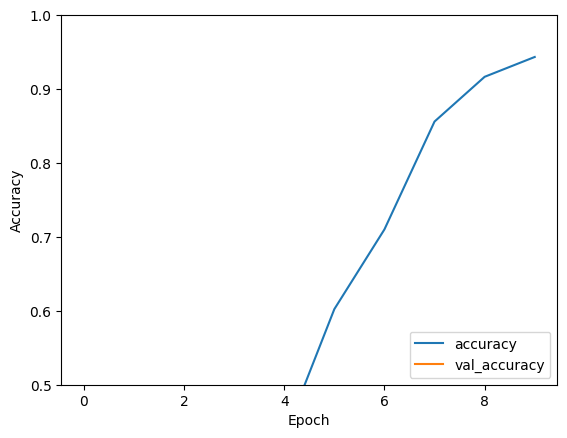

In [12]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

# Save model
model.save('CNN.keras')

In [21]:
model.save("CNN.keras")

In [1]:
import numpy as np
from PIL import Image
from keras.models import load_model
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
model = load_model('CNN.keras')

In [20]:
img_path = "face_0.jpg" #image to predict
img = load_img(img_path, target_size=(128, 128))  # Resize image
img_array = img_to_array(img) / 255.0  # Normalize the image (0-1)

img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

prediction = model.predict(img_array)
print(prediction)
prediction = name_labels[np.argmax(prediction)]
print(np.argmax(prediction))
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[1.2806599e-03 3.8421589e-03 4.2838418e-01 6.6711186e-03 3.9865711e-09
  9.0299132e-08 5.9553910e-05 8.2996301e-03 1.2352302e-04 8.8895869e-04
  4.9651530e-02 1.9493373e-04 5.5352524e-03 4.5215970e-04 2.3376035e-02
  1.3260560e-02 1.9985440e-03 2.3669468e-02 3.5086725e-10 9.3588087e-04
  1.2558375e-01 2.2773963e-01 3.8122241e-11 2.8139591e-09 2.8249787e-04
  3.3872663e-03 1.4463667e-03 1.2189654e-03 8.7355686e-05 1.9233433e-09
  7.1629964e-02]]
0
Akshay Kumar
